## Firstly we set up 8 dask workers

In [1]:
import numpy as np
import dask
from dask.distributed import Client, LocalCluster
import dask.bag as db

In [2]:
cluster = LocalCluster(n_workers=8)
# explicitly connect to the cluster we just created
client = Client(cluster)

In [3]:
client

Client Scheduler: tcp://127.0.0.1:41209 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 16 Memory: 61.38 GiB


## And we define a function

$$
g(x) = \sqrt{|x|} ^{\ln |x|}
$$

This is a test function for each pixel. In the real case we use an optimization workflow for each pixel.

In [14]:
def g(x):
    return np.sqrt(np.abs(x)) ** np.log(np.abs(x))

g(3)

1.8284607275312097

## ...and a large array

with 2 million pixels. Pixel values are normally distributed.

In [9]:
test_array = np.random.randn(2000000)

Now we are going to apply $g(x)$ to each pixel in the test array.

## Serial

In [15]:
%%time

results_serial = np.zeros((2000000, 1))
for i in range(len(test_array)):
    results_serial[i] = g(test_array[i])

CPU times: user 11.1 s, sys: 0 ns, total: 11.1 s
Wall time: 11 s


In [16]:
results_serial[[0, 1, 2, 3, 10, -10, -3, -2, -1]].flatten()

array([ 1.04644807,  1.0181662 ,  3.22965013,  1.10185788,  1.24392584,
        1.06371915, 14.13493006,  1.0373989 , 31.58783543])

## Parallel

Using `dask.bag`

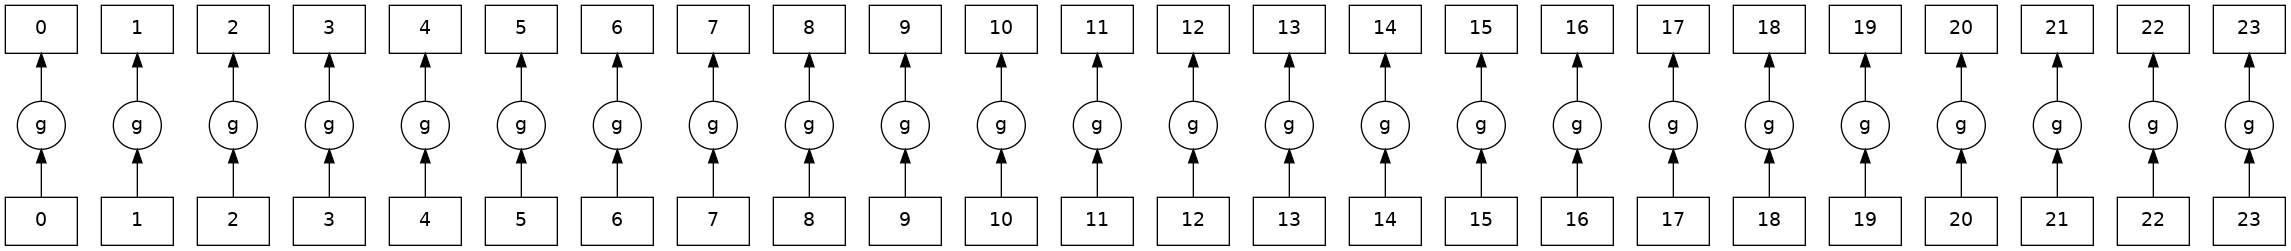

In [18]:
b = db.from_sequence(test_array, npartitions=24)
b = b.map(g)
b.visualize()

In [19]:
%%time
results_parallel = b.compute()

distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


CPU times: user 1min 16s, sys: 3.39 s, total: 1min 19s
Wall time: 1min 27s


In [20]:
results_parallel = np.array(results_parallel)
results_parallel[[0, 1, 2, 3, 10, -10, -3, -2, -1]]

array([ 1.04644807,  1.0181662 ,  3.22965013,  1.10185788,  1.24392584,
        1.06371915, 14.13493006,  1.0373989 , 31.58783543])

- Serial: **~11 s**
- Parallel (8 workers): **~1.5 min**

Why?